In [87]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

base = '/home1/john/SWRrefactored'
sys.path.append(f'{base}/code/')

from load_data_numpy import load_data_np
from SWRmodule import triangleSmooth
# from comodulogram import remove_session_string, get_filtered_signal
# from fooof import FOOOF

import statsmodels.formula.api as smf
from scipy.signal import decimate, resample, hilbert, welch, spectrogram
from mne.time_frequency import tfr_array_morlet

# # Import the time & event model objects and Bands object to manage oscillation band definitions
# from specparam import SpectralTimeModel, SpectralTimeEventModel, Bands
# # Import helper utilities for simulating and plotting spectrograms
# from specparam.sim import sim_spectrogram
# from specparam.plts.spectra import plot_spectrogram

# np.logspace(np.log10(80),np.log10(178),10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# for now the plotting code only works with one region at a time
region_name = ['ENT'] # ['ENT'] # ['AMY'] ['HPC']
subregion = [''] #['ca1'] # can use [''] to select ALL subregions
task = 'catFR1' # 'catFR1'
savePath = f'{base}/figures/'

# 1 for encoding, 0 for recall
encoding_mode_arr = [1] #,1] #[0,1] 
freq_range_str_arr = [[33.5,75],[80,120]] #,[7,9],[33.5,75],[80,120]] #[[33.5,75],[80,120]] #,[2,4],[7,9]] # [80,178]
# these were selecetd to avoid 60 and 120 Hz using np.logspace(np.log10(30),np.log10(75),10)

fs = 500 # sampling rate for raw data and ripples from createEventsForDF.py

In [90]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)

    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    
    start_cutoff = 0 # in samples
    if encoding_mode == 1: # raw is from -1.7 to 3.3 s from word_on
        saveName = 'encoding_'
        recall_str = ''
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        end_cutoff = 2500 # just take the whole range of data to better estimate Morlet     
 
    elif encoding_mode == 0: # raw is from -3 to 3 s from recall
        saveName = 'recall_'
        recall_str = '_recall'
        end_cutoff = 3000 # just take the whole range of data to better estimate Morlet       

    sr_factor = 1000/fs
    
    # Generate power_z
    
    load_anew = 0 # load power_z anew without saving or loading from previous runs
    
    print("Generating figures for run_mode: ", encoding_mode)
    power_z = None  # Initialize power_z as None
    if load_anew == 1: # if encoding need to save in pieces
        # for recall can load them all together in power_z
        power_z = load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,fs,start_cutoff, end_cutoff)
    else:
        for freq in freq_range_str_arr:
            saved_power_z_fn = f'/scratch/john/SWRrefactored/temp_dat/power_z_{task}_{saveName}{region_name[0]}_{subregion[0]}_freq{freq[0]}.npz'
            
            if power_z is None:
                if os.path.exists(saved_power_z_fn):
                    # Loading the file without creating a full copy in memory
                    power_z = np.load(saved_power_z_fn, mmap_mode='r')['power_z']
                else: # if hasn't been made yet: create power_z anew
                    power_z = load_z_scored_power(dd_trials, [freq], encoding_mode, fs, start_cutoff, end_cutoff)
                    power_z = np.expand_dims(power_z, axis=0)  # Add the first dimension
                    np.savez_compressed(saved_power_z_fn, power_z=power_z)
            else:
                if os.path.exists(saved_power_z_fn):
                    # Load the next frequency data directly into a new slice of power_z
                    next_slice = np.load(saved_power_z_fn, mmap_mode='r')['power_z']
                else:
                    next_slice = load_z_scored_power(dd_trials, [freq], encoding_mode, fs, start_cutoff, end_cutoff)
                    next_slice = np.expand_dims(next_slice, axis=0)  # Add the first dimension
                    np.savez_compressed(saved_power_z_fn, power_z=next_slice)
                # Append next_slice along the first dimension by expanding power_z
                import gc # import garbage collection
                power_z = np.concatenate((power_z, next_slice), axis=0)   
                del next_slice # delete and trigger garbage collection
                gc.collect()
        
    # note that output is 50 Hz (20 ms bins) since started 500 hz and decimated 10x
    if len(subregion[0]) > 0:
        subregion_str = f'_{subregion[0]}'
    else:
        subregion_str = ''           

a=1;            

Loading data
LOADING DATA FROM: ENT FOR EXPERIMENT catFR1
order: C
Generating figures for run_mode:  1


In [91]:
# info
dd_trials.keys()
np.shape(dd_trials['ripple'])
np.shape(dd_trials['raw'])

np.shape(power_z)
freq_range_str_arr

unique_subs = np.unique(dd_trials['subj'])
unique_subs

dict_keys(['ripple', 'clust', 'correct', 'recall_pos', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'serial_pos', 'raw', 'elec_by_elec_correlation', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'category_array', 'clust_int'])

(81984, 1500)

(81984, 2500)

(2, 81984, 250)

[[33.5, 75], [80, 120]]

array(['R1015J', 'R1026D', 'R1028M', 'R1045E', 'R1066P', 'R1067P',
       'R1083J', 'R1086M', 'R1108J', 'R1138T', 'R1144E', 'R1157C',
       'R1170J', 'R1180C', 'R1188C', 'R1217T', 'R1226D', 'R1230J',
       'R1247P', 'R1264P', 'R1274T', 'R1279P', 'R1310J', 'R1313J',
       'R1317D', 'R1330D', 'R1334T', 'R1337E', 'R1354E', 'R1361C',
       'R1364C', 'R1366J', 'R1367D', 'R1368T', 'R1372C', 'R1374T',
       'R1376D', 'R1379E', 'R1380D', 'R1381T', 'R1385E', 'R1386T',
       'R1387E', 'R1390M', 'R1393T', 'R1394E', 'R1396T', 'R1398J',
       'R1400N', 'R1405E', 'R1408N', 'R1412M', 'R1413D', 'R1414E',
       'R1421M', 'R1423E', 'R1426N', 'R1436J', 'R1449T', 'R1454M',
       'R1457T', 'R1463E', 'R1465D', 'R1468J', 'R1469D', 'R1473J',
       'R1474T', 'R1482J', 'R1484T', 'R1489E', 'R1491T', 'R1493T',
       'R1496T', 'R1501J', 'R1505J', 'R1515T', 'R1518T', 'R1525J',
       'R1527J', 'R1530J', 'R1536J', 'R1537T', 'R1541T', 'R1542J',
       'R1616S', 'R1627T', 'R1635T', 'R1640T', 'R1642J', 'R164

In [92]:
gamma_sd_thresh = -11.0
remove_first_recalls = 0 # if looking at recall might want to remove first recall of each list

# select a patient?
patient_idx = -1 # -1 means all

if patient_idx >-1: 
    sub_idxs = dd_trials['subj']==unique_subs[patient_idx]
else:
    sub_idxs = np.ones(len(dd_trials['subj']),dtype=bool)
print(f'Number of trials: {sum(sub_idxs)} from the following subs:')
np.unique(dd_trials['subj'][sub_idxs])

# if recalls remove the intrusions
if encoding_mode == 0:
    if remove_first_recalls:
        final_sub_idxs = (sub_idxs) & (clust!=0) & (dd_trials['recall_pos']!=1)
    else:
        final_sub_idxs = (sub_idxs) & (clust!=0)
else:
    final_sub_idxs = sub_idxs
      
# update each variable with indices
sub_ripples = dd_trials['ripple'][final_sub_idxs] # ripples are detected from -0.7 to 2.3 s @ 500 Hz
if power_z.ndim == 2:
    power_z = power_z[np.newaxis, :, :]
sub_Zs = power_z[:,final_sub_idxs,:]
sub_clust_ID = clust[final_sub_idxs]
np.shape(sub_Zs)

z_factor = sr_factor*10 # z_score was decimated 10x
if encoding_mode == 1:
    ripple_start_offset = -700 # ripple_trials go from -0.7 to 2.3 s (no buffers)
    ripple_analysis_start = 300 # time in ms
    ripple_analysis_end = 1300 # time in ms
    
    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((1700+ripple_analysis_start)/z_factor),int((1700+ripple_analysis_end)/z_factor)) # +1700 since goes from -1.7 to 3.3 s   
    plot_time_range = slice(int(1000/z_factor),int(4000/z_factor))
    time_bins = np.linspace(-0.7, 2.3, 150) # 100 bins from -0.2 to 2.0 seconds
    
elif encoding_mode == 0:
    ripple_start_offset = -2000 # ripple matrix 2000 ms on either side of recall
    ripple_analysis_start = -1900 # time in ms
    ripple_analysis_end = -100 # time in ms    

    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((3000+ripple_analysis_start)/z_factor),int((3000+ripple_analysis_end)/z_factor)) # +3000 since goes from -3 to 3 s
    plot_time_range = slice(int(1000/z_factor),int(5000/z_factor))
    time_bins = np.linspace(-2.0, 2.0, 200) # 100 bins from -0.2 to 2.0 seconds

# check power > thresh in gamma time range
z_low_gamma_trials = np.mean(sub_Zs[0,:,gamma_time_range],1)>=gamma_sd_thresh
if np.shape(sub_Zs)[0]>1:
    z_high_gamma_trials = np.mean(sub_Zs[1,:,gamma_time_range],1)>=gamma_sd_thresh     
    
ripple_trials = np.sum(sub_ripples[:,int((-ripple_start_offset+ripple_analysis_start)/sr_factor):
                                   int((-ripple_start_offset+ripple_analysis_end)/sr_factor)],1)>0
print(f'{sum(ripple_trials)} trials have ripples which is {np.round(100*sum(ripple_trials)/sum(final_sub_idxs),2)}% of total')


Number of trials: 81984 from the following subs:


array(['R1015J', 'R1026D', 'R1028M', 'R1045E', 'R1066P', 'R1067P',
       'R1083J', 'R1086M', 'R1108J', 'R1138T', 'R1144E', 'R1157C',
       'R1170J', 'R1180C', 'R1188C', 'R1217T', 'R1226D', 'R1230J',
       'R1247P', 'R1264P', 'R1274T', 'R1279P', 'R1310J', 'R1313J',
       'R1317D', 'R1330D', 'R1334T', 'R1337E', 'R1354E', 'R1361C',
       'R1364C', 'R1366J', 'R1367D', 'R1368T', 'R1372C', 'R1374T',
       'R1376D', 'R1379E', 'R1380D', 'R1381T', 'R1385E', 'R1386T',
       'R1387E', 'R1390M', 'R1393T', 'R1394E', 'R1396T', 'R1398J',
       'R1400N', 'R1405E', 'R1408N', 'R1412M', 'R1413D', 'R1414E',
       'R1421M', 'R1423E', 'R1426N', 'R1436J', 'R1449T', 'R1454M',
       'R1457T', 'R1463E', 'R1465D', 'R1468J', 'R1469D', 'R1473J',
       'R1474T', 'R1482J', 'R1484T', 'R1489E', 'R1491T', 'R1493T',
       'R1496T', 'R1501J', 'R1505J', 'R1515T', 'R1518T', 'R1525J',
       'R1527J', 'R1530J', 'R1536J', 'R1537T', 'R1541T', 'R1542J',
       'R1616S', 'R1627T', 'R1635T', 'R1640T', 'R1642J', 'R164

(2, 81984, 250)

9692 trials have ripples which is 11.82% of total


In [93]:
print(f"{len(np.unique(dd_trials['elec_labels'][sub_idxs]))} elecs")
print(f"from {len(np.unique(dd_trials['sess'][sub_idxs]))} sessions")
print(f"from {len(np.unique(dd_trials['subj'][sub_idxs]))} patients")

if region_name == ['ENT']:
    ENT_sess = np.unique(dd_trials['sess'][sub_idxs])
    ENT_sub = np.unique(dd_trials['subj'][sub_idxs])
elif region_name == ['HPC']:
    HPC_sess = np.unique(dd_trials['sess'][sub_idxs])
    HPC_sub = np.unique(dd_trials['subj'][sub_idxs])
elif region_name == ['AMY']:
    AMY_sess = np.unique(dd_trials['sess'][sub_idxs])
    AMY_sub = np.unique(dd_trials['subj'][sub_idxs])
    
save_sub_sess_info = 0

if save_sub_sess_info == 1:
    import pickle
    with open('../misc/region_data.pkl', 'wb') as f:
        pickle.dump({
            'ENT_sess': ENT_sess,
            'ENT_sub': ENT_sub,
            'HPC_sess': HPC_sess,
            'HPC_sub': HPC_sub,
            'AMY_sess': AMY_sess,
            'AMY_sub': AMY_sub
        }, f)   

475 elecs
from 224 sessions
from 100 patients


## create indices for various ripple/gamma combos

In [94]:
num_trials = np.shape(ripple_trials)[0]
print(f'number of ripple trials: {sum(ripple_trials)} of total {num_trials} trials ({100*np.round(sum(ripple_trials)/num_trials,4)} %)')

low_gamma_only = z_low_gamma_trials # & ripple_trials #z_low_gamma_trials & ~ripple_trials
print(f'number of low gamma trials > {gamma_sd_thresh} SD with no ripples: {sum(low_gamma_only)}') 

low_gamma_ripple = z_low_gamma_trials # & ~ripple_trials #z_high_gamma_trials #& ~ripple_trials
print(f'number of high gamma trials > {gamma_sd_thresh} SD with no ripples: {sum(low_gamma_ripple)}')

low_gamma_no_ripple = z_high_gamma_trials# & ripple_trials #z_low_gamma_trials & ~ripple_trials & ~z_high_gamma_trials
print(f'number of low gamma trials > {gamma_sd_thresh} SD with no ripples/no high gamma: {sum(low_gamma_no_ripple)}')

low_gamma_no_ripple_no_high_gamma = z_high_gamma_trials# & ~ripple_trials # & ~z_high_gamma_trials
print(f'number of high gamma trials > {gamma_sd_thresh} SD with no ripples/no low gamma: {sum(low_gamma_no_ripple_no_high_gamma)}')

trial_combos = [low_gamma_only,low_gamma_ripple,low_gamma_no_ripple,low_gamma_no_ripple_no_high_gamma] # all 4 combos above
clust = dd_trials['clust_int'][final_sub_idxs]

np.shape(sub_Zs)

number of ripple trials: 9692 of total 81984 trials (11.82 %)
number of low gamma trials > -11.0 SD with no ripples: 81984
number of high gamma trials > -11.0 SD with no ripples: 81984
number of low gamma trials > -11.0 SD with no ripples/no high gamma: 81983
number of high gamma trials > -11.0 SD with no ripples/no low gamma: 81983


(2, 81984, 250)

# plot low and high gamma after removing ripples
## assumes freq_range_str_arr = [[33.5,75],[80,120]] above)

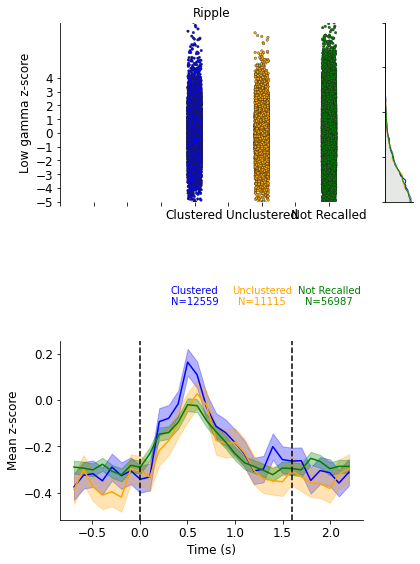

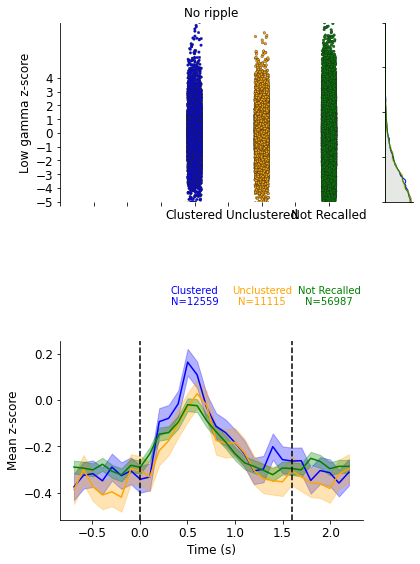

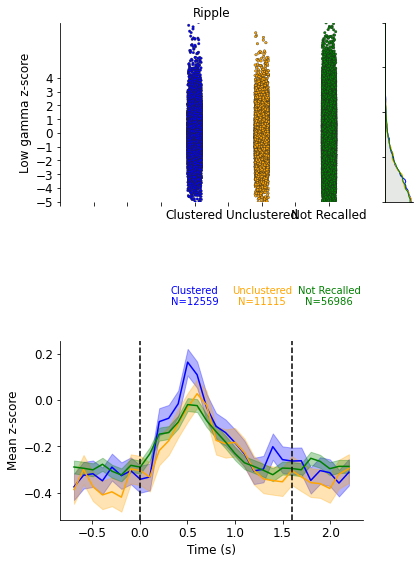

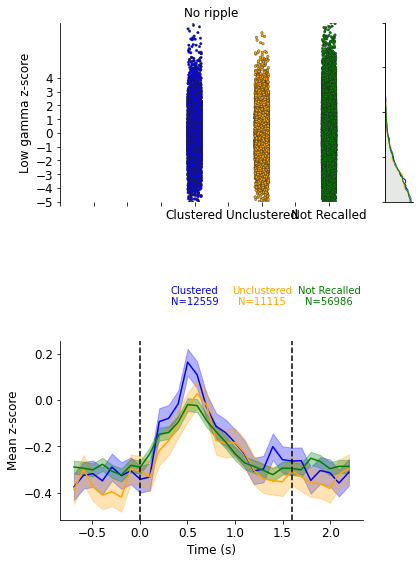

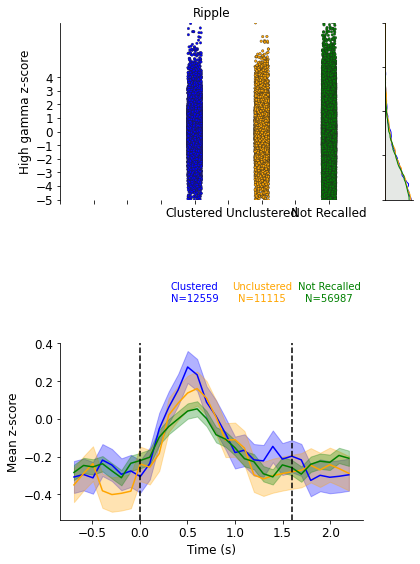

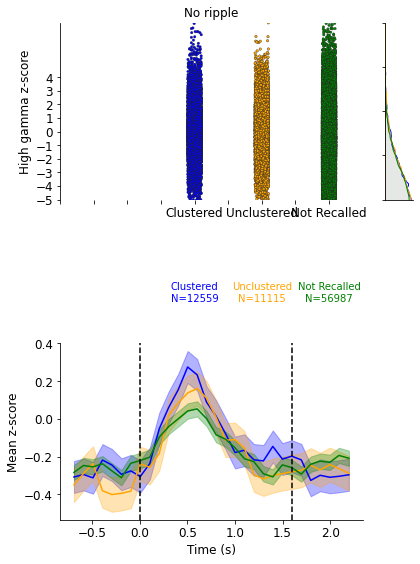

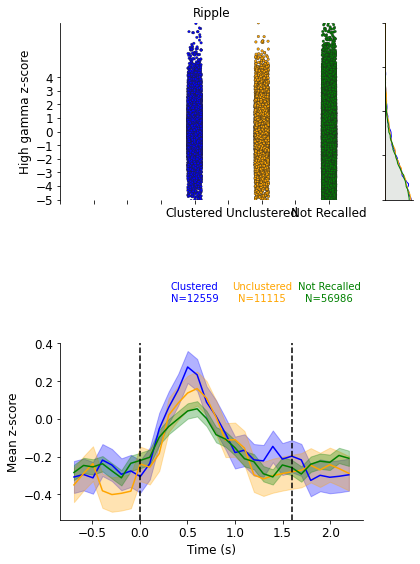

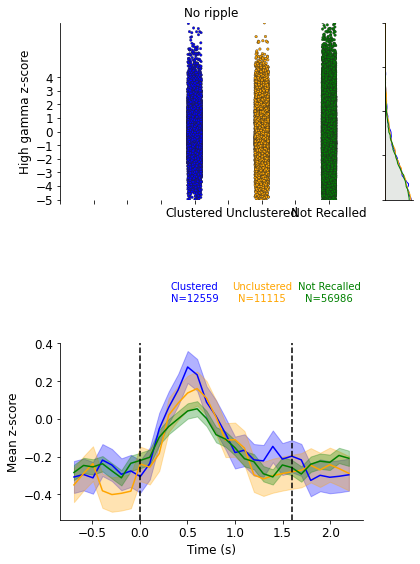

In [95]:
from scipy.signal import decimate
import matplotlib.gridspec as gridspec

smoothing_triangle = 5
swarm_ylimits = [0, 8.0]  # [-4.0,8.0]

font_size = 12
plt.rcParams.update({'font.size': font_size})
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}
label_strings = ['Clustered', 'Unclustered', 'Not Recalled']
clust_clustered = clust > 1
clust_unclustered = clust < 0
clust_not_recalled = clust == 0
trial_sums = sum(trial_combos,1)
if encoding_mode == 1:
    plot_vars = [clust_clustered, clust_unclustered, clust_not_recalled]
    figsize = [6,8]
else:
    plot_vars = [clust_clustered, clust_unclustered]
    figsize = [4,6]    

for i_plot, plot_set in enumerate(range(np.shape(sub_Zs)[0])):
    
    freq_range = freq_range_str_arr[i_plot]
    if 29 < freq_range[0] < 35:
        ylabel = 'Low gamma z-score'
    elif 65 < freq_range[0] < 90:
        ylabel = 'High gamma z-score' 
    elif 1 < freq_range[0] < 3:
        ylabel = 'Low theta z-score'
    elif 6 < freq_range[0] < 8:
        ylabel = 'High theta z-score'
    
    for combo_num, trial_idxs in enumerate(trial_combos):
        # note that these include adjacent temporal so won't necessarily add to combined trials below
        if combo_num == 0:
            title = 'Ripple' #f'Low gamma only, N={trial_sums[0]}' #'Low gamma no ripples'
        elif combo_num == 1:
            title = 'No ripple' #f'Low gamma ripple trials, N={trial_sums[1]}' #'High gamma no ripples'            
        elif combo_num == 2:
            title = 'Ripple' #f'Low gamma no ripple trials, N={trial_sums[2]}' #'Low gamma no ripples/no high gamma'            
        elif combo_num == 3:            
            title = 'No ripple' #f'Low gamma no ripple no high gamma, N={trial_sums[3]}' #'High gamma no ripples/no low gamma'
            
        # Combine the data for swarm two (Ripple (yes low gamma))
        swarm_clustered = sub_Zs[i_plot, trial_idxs & clust_clustered, gamma_time_range].mean(axis=1)
        swarm_unclustered = sub_Zs[i_plot, trial_idxs & clust_unclustered, gamma_time_range].mean(axis=1)
        if encoding_mode == 1:
            swarm_not_recalled = sub_Zs[i_plot, trial_idxs & clust_not_recalled, gamma_time_range].mean(axis=1)
            data_combined = np.concatenate([swarm_clustered, swarm_unclustered, swarm_not_recalled])
            # Create simplified labels for each group
            labels = ([label_strings[0]] * len(swarm_clustered) +
                      [label_strings[1]] * len(swarm_unclustered) +
                      [label_strings[2]] * len(swarm_not_recalled))            
        else:
            data_combined = np.concatenate([swarm_clustered, swarm_unclustered])
            labels = ([label_strings[0]] * len(swarm_clustered) +
                      [label_strings[1]] * len(swarm_unclustered))


        # Set up the figure with GridSpec
        fig = plt.figure(figsize=figsize)  # Adjusted figure size
        gs = gridspec.GridSpec(2, 4, height_ratios=[2, 2], width_ratios=[3,3,3,1])  # 4th column for kde

        # Create the swarmplot (span all columns)
        ax_swarm = fig.add_subplot(gs[0, :3])
        sb.stripplot(x=labels, y=data_combined, palette=[palette['Clustered'], palette['Unclustered'], palette['Not Recalled']],
                     size=2.5, jitter=True, dodge=True, linewidth=0.35)
#         sb.swarmplot(x=labels, y=data_combined, palette=[palette['Clustered'], palette['Unclustered'], palette['Not Recalled']], size=1.5)        

        ax_swarm.set_ylabel(ylabel, color='black')  # Adjust color to your preference
        ax_swarm.set_xlabel('')
        ax_swarm.set_ylim(swarm_ylimits)
        ax_swarm.set_xticks([])  # Remove x-ticks
        ax_swarm.spines['top'].set_visible(False)  # Remove top spine
        ax_swarm.spines['right'].set_visible(False)  # Remove right spine
        ax_swarm.spines['bottom'].set_visible(False)
        ax_swarm.set_title(title,fontsize=font_size)
    
        # Add the number of trials below 
        for i_label, clust_idx in enumerate(plot_vars):
            trial_count = sum(trial_idxs & clust_idx)
            ax_swarm.text(i_label, gamma_sd_thresh-0.85, f'{label_strings[i_label]}\nN={trial_count}', ha='center', va='center', fontsize=10, 
                          color=palette[label_strings[i_label]])
        for label in ax_swarm.get_xticklabels():
            text = label.get_text()
            if text == 'Clustered':
                label.set_color(palette['Clustered'])
            elif text == 'Unclustered':
                label.set_color(palette['Unclustered'])
            elif text == 'Not Recalled':
                label.set_color(palette['Not Recalled'])            

        # Add the KDE plot to the right of the strip plots
        ax_kde = fig.add_subplot(gs[0, 3])

        # Plot KDE for each category separately
        alpha = 0.05
        sb.kdeplot(y=swarm_clustered, ax=ax_kde, color=palette['Clustered'], fill=True, label='Clustered', alpha=alpha, bw_adjust=0.25)
        sb.kdeplot(y=swarm_unclustered, ax=ax_kde, color=palette['Unclustered'], fill=True, label='Unclustered', alpha=alpha, bw_adjust=0.25)
        sb.kdeplot(y=swarm_not_recalled, ax=ax_kde, color=palette['Not Recalled'], fill=True, label='Not Recalled', alpha=alpha, bw_adjust=0.25)

        ax_kde.set_ylim(swarm_ylimits)  # Adjust limits based on your data
        ax_kde.set_ylabel('')  # Remove ylabel
        ax_kde.set_yticklabels('')
        ax_kde.set_xlabel('')  
        ax_kde.set_xticks([])  # Remove x-ticks
        ax_kde.spines['top'].set_visible(False)  # Remove top spine
        ax_kde.spines['right'].set_visible(False)  # Remove right spine

        # PSTH plots
        
        # Decimate time bins
        decimation_factor = 5
        time_bins_decimated = decimate(time_bins, decimation_factor)
        
        def mean_and_se(data):
            mean = data.mean(axis=0)
            se = data.std(axis=0) / np.sqrt(data.shape[0])
            return mean, se        
        mean_swarm_clustered, se_swarm_clustered = mean_and_se(sub_Zs[i_plot, trial_idxs & clust_clustered, plot_time_range])
        mean_swarm_unclustered, se_swarm_unclustered = mean_and_se(sub_Zs[i_plot, trial_idxs & clust_unclustered, plot_time_range])        
        
        ax_psth = fig.add_subplot(gs[1, :3])  # Only one plot here
        ax_psth.plot(time_bins_decimated, decimate(mean_swarm_clustered, decimation_factor), label='Clustered', color=palette['Clustered'])
        ax_psth.fill_between(time_bins_decimated, 
                                  decimate(mean_swarm_clustered, decimation_factor) - decimate(se_swarm_clustered, decimation_factor),
                                  decimate(mean_swarm_clustered, decimation_factor) + decimate(se_swarm_clustered, decimation_factor), 
                                  alpha=0.3, color=palette['Clustered'])
        ax_psth.plot(time_bins_decimated, decimate(mean_swarm_unclustered, decimation_factor), label='Unclustered', color=palette['Unclustered'])
        ax_psth.fill_between(time_bins_decimated, 
                                  decimate(mean_swarm_unclustered, decimation_factor) - decimate(se_swarm_unclustered, decimation_factor),
                                  decimate(mean_swarm_unclustered, decimation_factor) + decimate(se_swarm_unclustered, decimation_factor), 
                                  alpha=0.3, color=palette['Unclustered'])
        if encoding_mode == 1:
            mean_swarm_not_recalled, se_swarm_not_recalled = mean_and_se(sub_Zs[i_plot, trial_idxs & clust_not_recalled, plot_time_range])
            ax_psth.plot(time_bins_decimated, decimate(mean_swarm_not_recalled, decimation_factor), label='Not Recalled', color=palette['Not Recalled'])
            ax_psth.fill_between(time_bins_decimated, 
                                      decimate(mean_swarm_not_recalled, decimation_factor) - decimate(se_swarm_not_recalled, decimation_factor),
                                      decimate(mean_swarm_not_recalled, decimation_factor) + decimate(se_swarm_not_recalled, decimation_factor), 
                                      alpha=0.3, color=palette['Not Recalled'])
        ax_psth.axvline(x=0.0, color='black', linestyle='--')
        if encoding_mode == 1:    
            ax_psth.axvline(x=1.6, color='black', linestyle='--')
        ax_psth.set_xlabel('Time (s)')
        ax_psth.set_ylabel('Mean z-score')

        # Remove top and right spines for PSTH
        ax_psth.spines['top'].set_visible(False)
        ax_psth.spines['right'].set_visible(False)
        ax_swarm.set_ylim(swarm_ylimits)
        ax_swarm.set_yticks(np.arange(-5,5,1))
        ax_swarm.set_xticks(np.arange(-2,2.01,0.5))

#         # Color the axis labels according to the bar color above them
#         for ticklabel, color in zip(ax_psth.get_xticklabels(), [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]):
#             ticklabel.set_color(color)
#         for ticklabel, color in zip(ax_psth.get_yticklabels(), [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]):
#             ticklabel.set_color(color)

        # Adjust layout to ensure the plots align correctly
        plt.tight_layout(h_pad=2)
        plt.show()
a=1;

In [ ]:
ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)

start_array,_ = getStartEndArrays(sub_ripples)

# first bin has artificially high number due to how start_srray works
start_array = start_array[:,1:] 
print(f'start array shape: {np.shape(start_array)}')

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Flatten the ripple data for easier modeling
ripple_data = start_array[:, ripple_swarm_start:ripple_swarm_end].sum(axis=1)
low_gamma_data = sub_Zs[0, :, gamma_time_range].mean(axis=1)
high_gamma_data = sub_Zs[1, :, gamma_time_range].mean(axis=1)

# Create a DataFrame with the data
df = pd.DataFrame({
    'ripple_rate': ripple_data,
    'clust_clustered': (sub_clust_ID > 1).astype(int),
    'clust_unclustered': (sub_clust_ID < 0).astype(int),
    'clust_not_recalled': (sub_clust_ID == 0).astype(int),
    'session': dd_trials['sess'][final_sub_idxs],
    'subject': dd_trials['subj'][final_sub_idxs],
    'low_gamma': low_gamma_data,
    'high_gamma': high_gamma_data
})

# Define the model formula
# 'ripple_rate ~ clust_clustered + clust_unclustered + clust_not_recalled' specifies the fixed effects
# '(1 | subject/session)' specifies the random effects, with session nested within subject
if encoding_mode == 1:
    formula = "low_gamma ~ ripple_rate*(clust_clustered + clust_unclustered)"
elif encoding_mode == 0:
    formula = "low_gamma ~ ripple_rate*clust_clustered" # since not recalled doesn't exist
model = mixedlm(
                formula=formula,data=df, groups=df["subject"], vc_formula={"session": "0 + session"},
                re_formula = 'ripple_rate*clust_clustered'
                )

print(model.fit().summary())